In [58]:
import gc
import datetime
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


## EDA

In [3]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

In [5]:
df.head()

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1


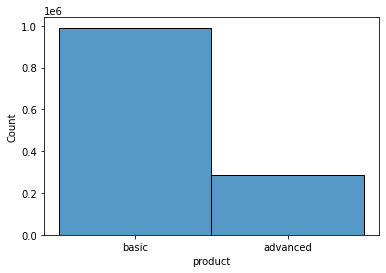

In [6]:
sns.histplot(df['product'])
plt.show()

In [8]:
df.describe()

,user_id,amount,transactions
count,1.278186e+06,1.278186e+06,1.278186e+06
mean,4.614241e+18,2.394618e+02,1.292690e+00
std,2.657074e+18,3.719033e+02,1.511153e+00
min,1.809139e+12,8.000000e+00,1.000000e+00
25%,2.311730e+18,8.900000e+01,1.000000e+00
50%,4.622499e+18,1.490000e+02,1.000000e+00
75%,6.906575e+18,2.590000e+02,1.000000e+00
max,9.223367e+18,1.081860e+05,7.680000e+02


In [9]:
df.shape

(1278186, 5)

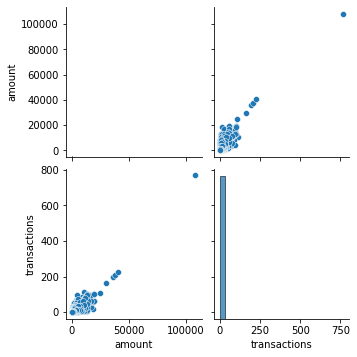

In [12]:
sns.pairplot(df[['amount', 'transactions']])
plt.show()

Давайте проверим выбросы, потому что график справа сверху выглядит очень подозрительно.

In [26]:
df['transactions'].describe()

count    1.278186e+06
mean     1.292690e+00
std      1.511153e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      7.680000e+02
Name: transactions, dtype: float64

Очевидно, что вряд ли можно сделать 768 транзакций, проверим, сколько таких людей.

In [32]:
df[df['transactions'] > 45]['transactions'].sum() / df.shape[0]

0.006384829750912622

Отсеим по количеству транзакций - 45 выглядит тем числом, на котором можно отрезать.

In [33]:
df = df[df.transactions <= 45]

Проверим теперь по тратам за день.

In [51]:
df['amount'].describe()

count    1.278076e+06
mean     2.384950e+02
std      3.407736e+02
min      8.000000e+00
25%      8.900000e+01
50%      1.490000e+02
75%      2.590000e+02
max      1.882500e+04
Name: amount, dtype: float64

In [37]:
df['amount'].quantile(0.99)

1540.25

In [41]:
outliners = df[df['amount'] > 1540].sort_values('amount', ascending=False)

In [42]:
outliners.columns

Index(['event_date', 'user_id', 'product', 'amount', 'transactions'], dtype='object')

In [43]:
outliners['product'].value_counts()

advanced    10087
basic        2694
Name: product, dtype: int64

In [44]:
outliners[outliners['product'] == 'basic']

,event_date,user_id,product,amount,transactions
562743,2020-11-05,7699056396741081739,basic,12489.0,45
730316,2020-11-30,7699056396741081739,basic,11470.0,42
546857,2020-11-16,7699056396741081739,basic,11409.0,41
223095,2020-10-15,7699056396741081739,basic,11344.0,40
9330,2020-10-01,7699056396741081739,basic,11344.0,40
...,...,...,...,...,...
845729,2020-12-11,4546421420977369980,basic,1542.0,8
902878,2020-12-12,4546421420977369980,basic,1542.0,8
1276098,2020-12-25,4546421420977369980,basic,1542.0,8
439679,2020-10-27,1244741023630484055,basic,1541.0,7


In [59]:
del outliners
gc.collect()

17418

Посмотрим на подозрительного пользователя, у него крайне странные большие траты и большое количество транзакций.

In [47]:
df[df['user_id'] == 7699056396741081739].sort_values('event_date')

,event_date,user_id,product,amount,transactions
9330,2020-10-01,7699056396741081739,basic,11344.0,40
121882,2020-10-08,7699056396741081739,basic,11344.0,40
223095,2020-10-15,7699056396741081739,basic,11344.0,40
273479,2020-10-19,7699056396741081739,basic,3443.0,13
256167,2020-10-26,7699056396741081739,basic,3108.0,12
562743,2020-11-05,7699056396741081739,basic,12489.0,45
388561,2020-11-09,7699056396741081739,basic,10844.0,40
684605,2020-11-12,7699056396741081739,basic,8836.0,32
546857,2020-11-16,7699056396741081739,basic,11409.0,41
653007,2020-11-23,7699056396741081739,basic,10002.0,36


Сложно оценить, на сколько фродовый, ведь есть достаточно неплохая тенденция, возможно оптовый покупатель. Проверим на удельной величине, то есть средний чек на одну транзакцию.

In [49]:
df.loc[:, 'avg_amount'] = df['amount'] / df['transactions']

In [50]:
df[df['user_id'] == 7699056396741081739][['avg_amount', 'event_date']].sort_values('event_date')

,avg_amount,event_date
9330,283.600000,2020-10-01
121882,283.600000,2020-10-08
223095,283.600000,2020-10-15
273479,264.846154,2020-10-19
256167,259.000000,2020-10-26
562743,277.533333,2020-11-05
388561,271.100000,2020-11-09
684605,276.125000,2020-11-12
546857,278.268293,2020-11-16
653007,277.833333,2020-11-23


Кажется, что поведение клиента весьма адекватно, потому как он делает стабильно плюс-минус одинаковые траты. Тем ни менее посмотрим, сколько в среднем тратят на одну транзакцию клиенты с тарифом basic.

In [54]:
df.groupby('product')['avg_amount'].mean()

product
advanced    388.849416
basic       127.696219
Name: avg_amount, dtype: float64

In [56]:
df.groupby('product')['avg_amount'].quantile(0.99)

product
advanced    1399.0
basic        399.0
Name: avg_amount, dtype: float64

Не будем дальше отрезать, кажется, что отсечения по числу транзакций хватило. Посмотрим баланс продуктов.

In [57]:
df['product'].value_counts()

basic       990348
advanced    287728
Name: product, dtype: int64

В целом есть небольшая расбалансировка, но в целом не так уж сильно критично. 

Проверим еще есть ли такие клиенты, которые используют сразу 2 пакета.

In [332]:
df.shape[0] - df[df['product'] == 'basic'].shape[0] - df[df['product'] == 'advanced'].shape[0]

0

Окей, посмотрим взаимосвязи величин через pairplot

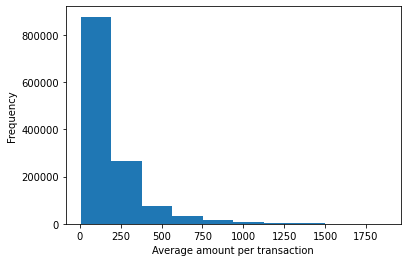

In [63]:
df['avg_amount'].plot.hist()
plt.xlabel('Average amount per transaction')
plt.show()

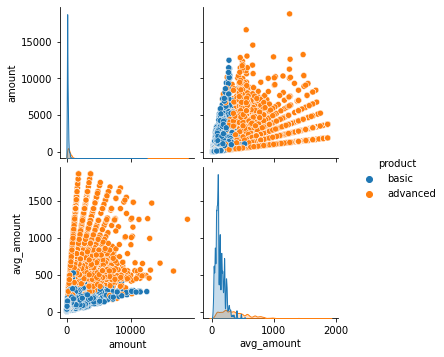

Wall time: 2min 38s


In [66]:
%%time
sns.pairplot(df[['amount', 'product', 'avg_amount']], hue='product')
plt.show()

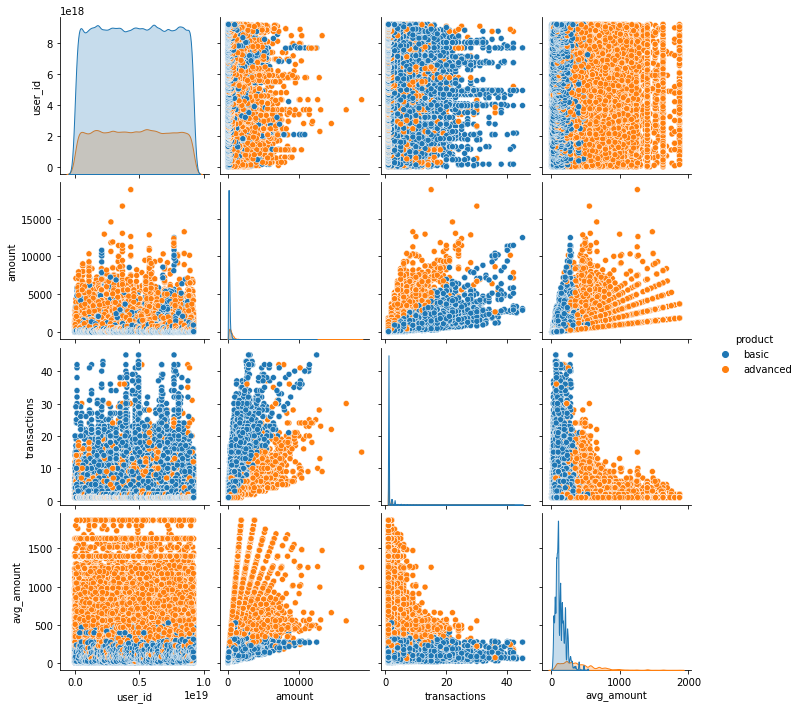

In [64]:
sns.pairplot(df, hue='product')

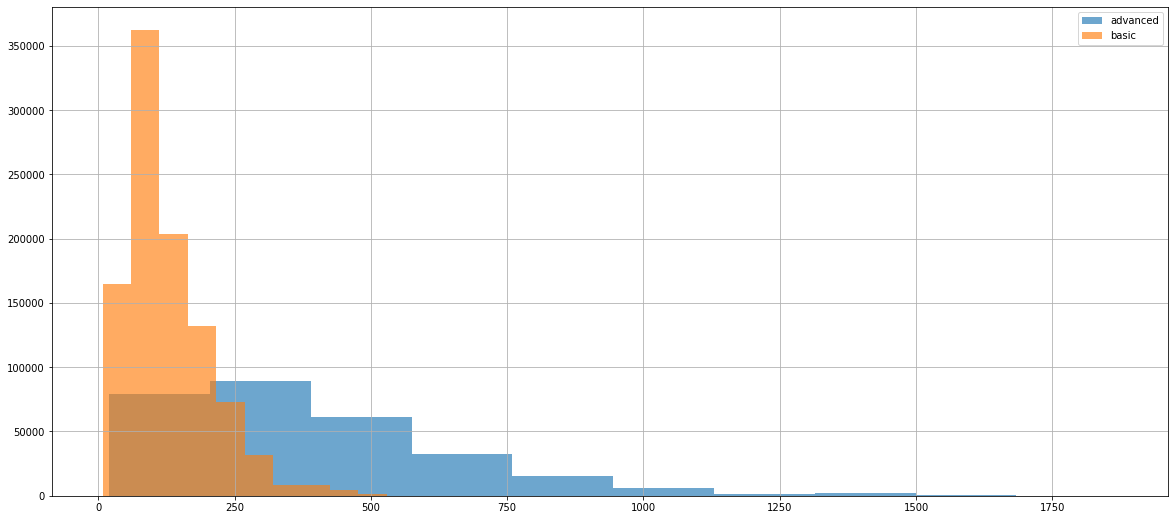

In [69]:
plt.figure(figsize=(20, 9))
df.groupby('product')['avg_amount'].hist(legend=True, alpha=0.65)
plt.show()

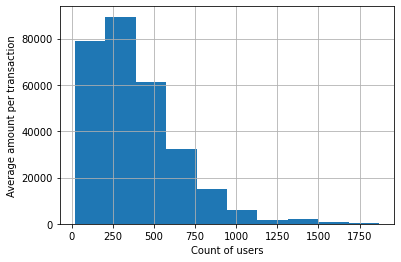

In [72]:
df[df['product'] == 'advanced']['avg_amount'].hist()
plt.xlabel('Count of users')
plt.ylabel('Average amount per transaction')
plt.show()

In [73]:
df.groupby('product')['avg_amount'].mean()

product
advanced    388.849416
basic       127.696219
Name: avg_amount, dtype: float64

У нас средний чек у продвинутого продукта примерно в 3 раза выше, при условии, что количество людей у продвинутого так же приблизительно в 3 раза меньше. Посмотрим, сколько принесли нам пользователи и того, и другого продукта.

In [75]:
df.groupby('product')['amount'].sum()

product
advanced    143152606.0
basic       161662104.0
Name: amount, dtype: float64

Различие крайне маленькое, то есть кажется, что наша гипотеза касательно информирования может дать хороший результат.

Посмотрим теперь на распределение по времени, чтобы посмотреть сезонность.

In [76]:
df['event_date'].dtype

dtype('<M8[ns]')

In [79]:
min_date = df['event_date'].min()
max_date = df['event_date'].max()

(max_date - min_date).days

91

In [81]:
min_date

Timestamp('2020-09-29 00:00:00')

In [80]:
max_date

Timestamp('2020-12-29 00:00:00')

Итого, данные за 3 месяца, странно говорить о сезонности в это, но давайте сделаем некоторые бакеты, скажем, в неделю (вспомним того подозрительного клиента, у которого есть покупки в неделю). Предварительно посмотрим в день.

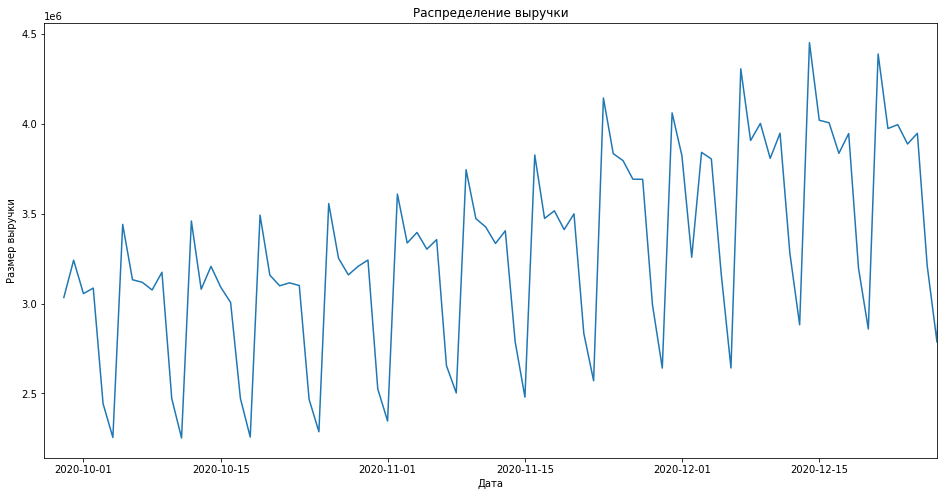

In [204]:
df_resample = df.copy()
to_plot_resample_d = df_resample.set_index('event_date')[['amount', 'transactions']].resample('d', label='left').sum()
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_d.index, to_plot_resample_d['amount'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение выручки')
plt.xlabel('Дата')
plt.ylabel('Размер выручки')
plt.show()

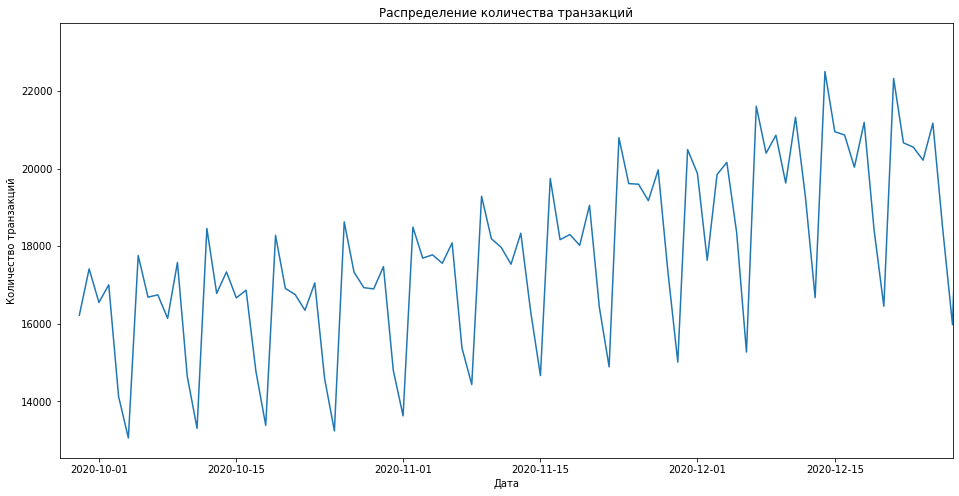

In [205]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_d.index, to_plot_resample_d['transactions'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение количества транзакций')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.show()

Сезонность очевидно есть.

In [103]:
df_resample = df.copy()
to_plot_resample = df_resample.set_index('event_date')[['amount', 'transactions']].resample('W', label='left').sum()

In [86]:
to_plot_resample.head()

,amount,transactions
event_date,,
2020-09-27,17115233.0,94363
2020-10-04,20666002.0,112854
2020-10-11,20573313.0,114256
2020-10-18,20720099.0,113166
2020-10-25,21291043.0,115679


In [89]:
to_plot_resample.tail()

,amount,transactions
event_date,,
2020-11-29,24599496.0,131626
2020-12-06,26137944.0,139779
2020-12-13,26317568.0,140431
2020-12-20,26192269.0,139357
2020-12-27,8461461.0,44835


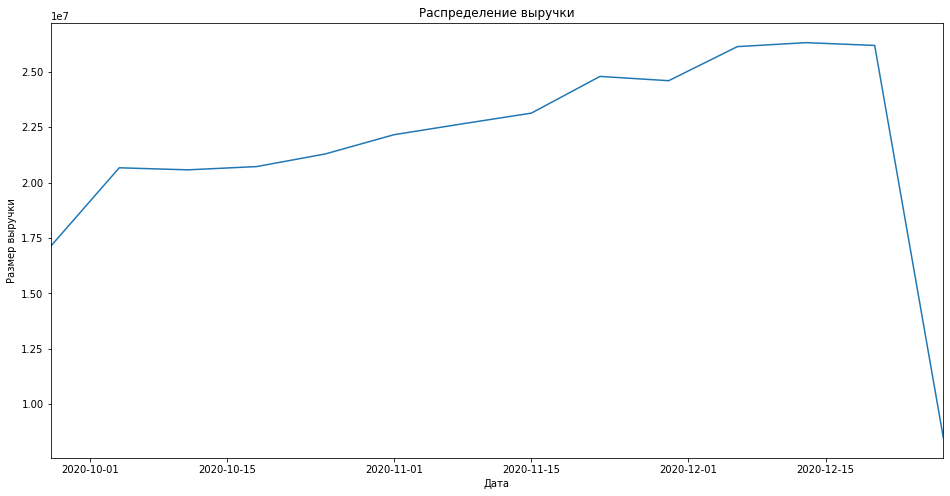

In [107]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample.index, to_plot_resample['amount'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение выручки')
plt.xlabel('Дата')
plt.ylabel('Размер выручки')
plt.show()

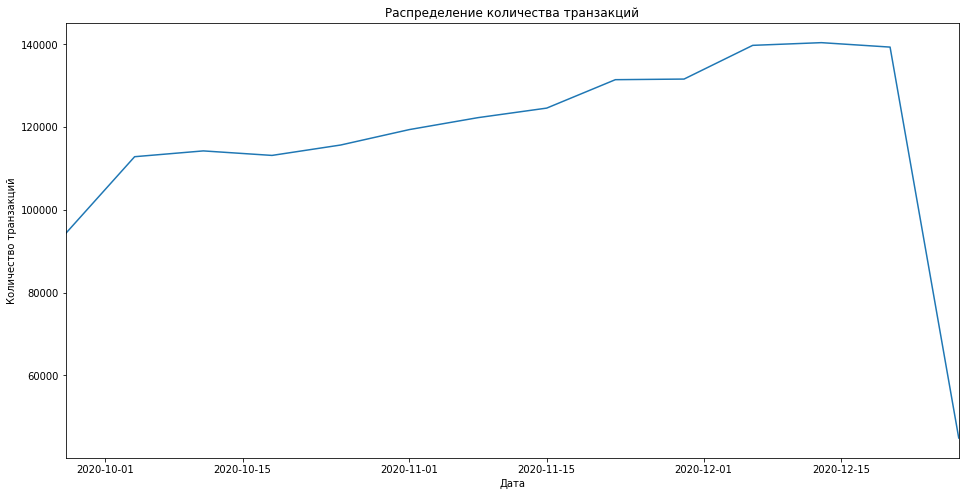

In [97]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample.index, to_plot_resample['transactions'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение количества транзакций')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.show()

In [93]:
to_plot_resample_m = df_resample.set_index('event_date')[['amount', 'transactions']].resample('m', label='left').sum()

Посмотрим для помесячного рассмотрения (всего 3 точки, но все равно интересно).

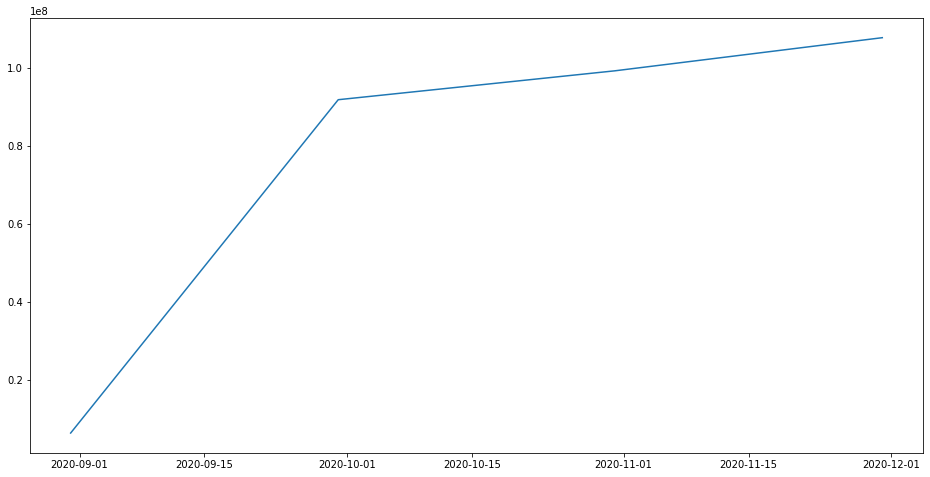

In [94]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_m.index, to_plot_resample_m['amount'])
#plt.xlim('2020-09-27', '2020-12-27')
plt.show()

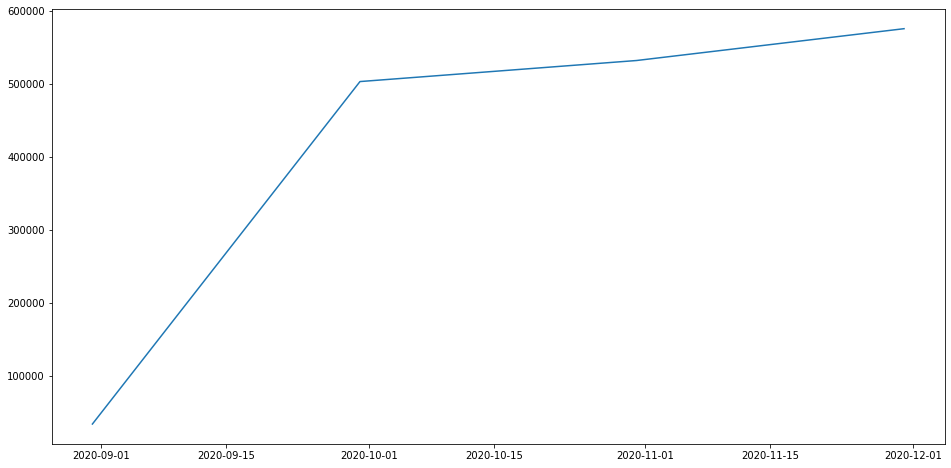

In [98]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_m.index, to_plot_resample_m['transactions'])
#plt.xlim('2020-09-27', '2020-12-27')
plt.show()

Видим, что к концу году наблюдается рост выручки и числа транзакций, то есть наши покупатели более склонны делать покупки ближе к концу года, проверим это гипотезу на средних значений выручки и транзакций в неделю. Будем усреднять на одного клиента.

In [104]:
to_plot_resample_w = df_resample.set_index('event_date')[['amount', 'transactions']]\
                                .resample('W', label='left').mean()

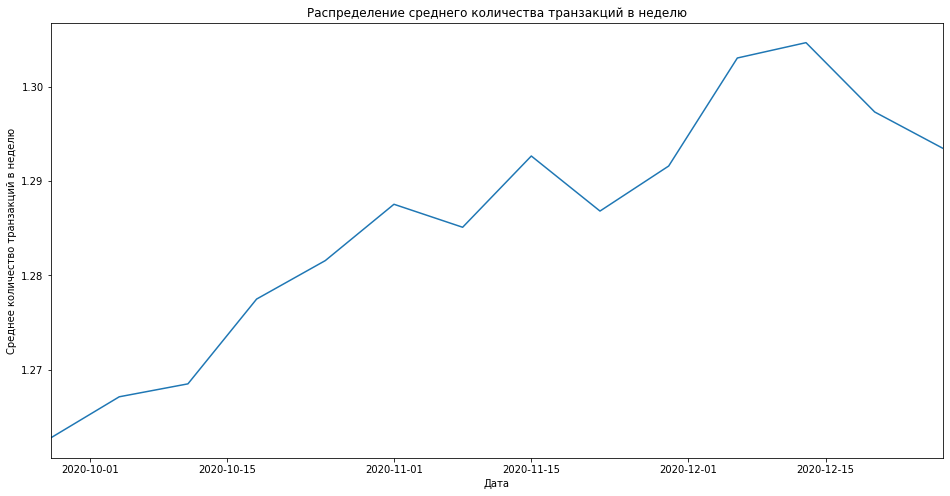

In [105]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_w.index, to_plot_resample_w['transactions'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение среднего количества транзакций в неделю')
plt.xlabel('Дата')
plt.ylabel('Среднее количество транзакций в неделю')
plt.show()

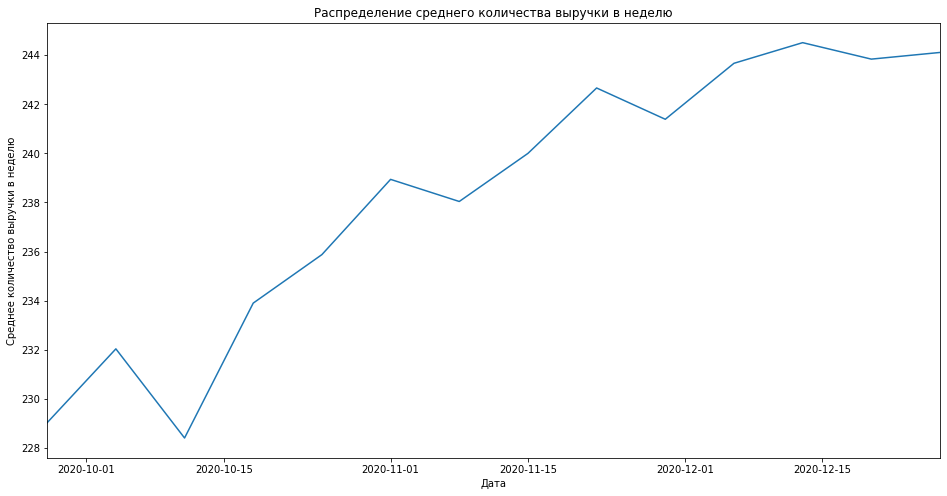

In [106]:
plt.figure(figsize=(16, 8))
plt.plot(to_plot_resample_w.index, to_plot_resample_w['amount'])
plt.xlim('2020-09-27', '2020-12-27')
plt.title('Распределение среднего количества выручки в неделю')
plt.xlabel('Дата')
plt.ylabel('Среднее количество выручки в неделю')
plt.show()

Сезонность в данных есть - к концу года наблюдается рост метрик.

In [110]:
df_indexed = df.set_index('event_date')

In [117]:
df_agg_product_date = df.groupby(['product', 'event_date'])['user_id'].count()

In [118]:
df_agg_product_date.head()

product   event_date
advanced  2020-09-29    2967
          2020-09-30    3105
          2020-10-01    2896
          2020-10-02    2897
          2020-10-03    2440
Name: user_id, dtype: int64

In [120]:
df_agg_product_date = df_agg_product_date.unstack(level=0)

In [123]:
df_agg_product_date['ratio'] = df_agg_product_date['advanced'] / df_agg_product_date.sum(axis=1)

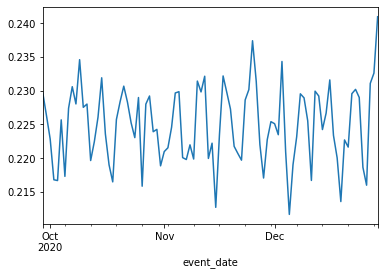

In [129]:
df_agg_product_date['ratio'].plot()
plt.show()

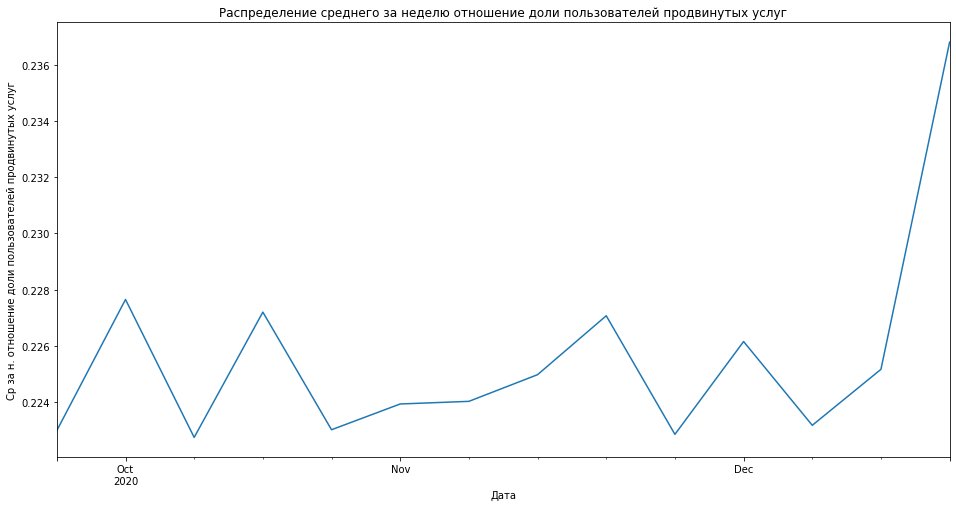

In [134]:
plt.figure(figsize=(16,8))
df_agg_product_date.resample('W', label='left')['ratio'].mean().plot()
plt.title('Распределение среднего за неделю отношение доли пользователей продвинутых услуг')
plt.ylabel('Ср за н. отношение доли пользователей продвинутых услуг')
plt.xlabel('Дата')
plt.show()

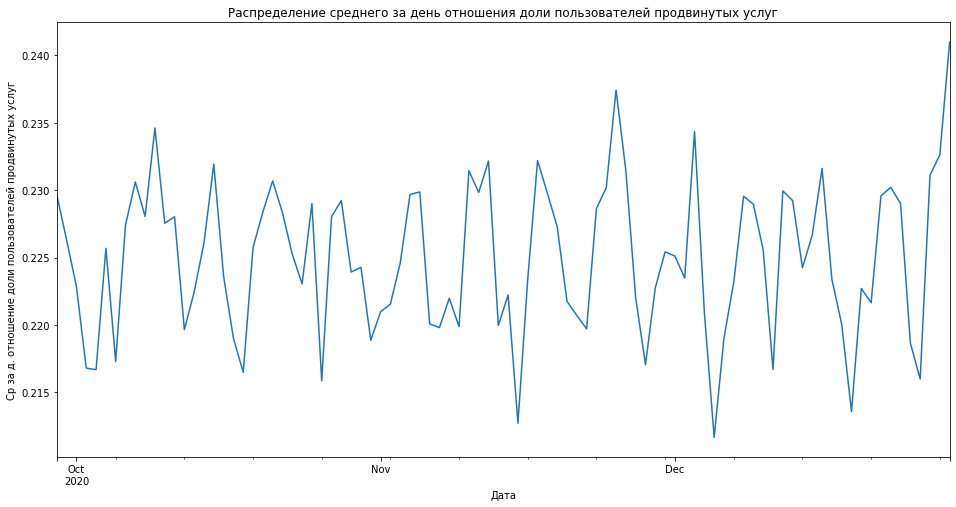

In [136]:
plt.figure(figsize=(16,8))
df_agg_product_date['ratio'].plot()
plt.title('Распределение среднего за день отношения доли пользователей продвинутых услуг')
plt.ylabel('Ср за д. отношение доли пользователей продвинутых услуг')
plt.xlabel('Дата')
plt.show()

In [ ]:
df_agg_product_date.resample('W', label='left').

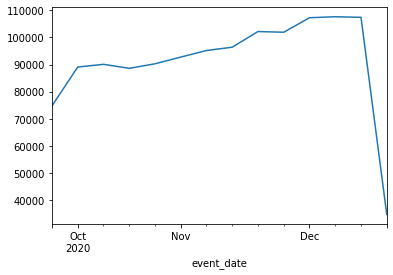

In [113]:
df_indexed.resample('W', label='left')['user_id'].count().plot()
plt.show()

### Формализация гипотез

Так как одна наша предполагаемые гипотезы связаны с конкретным продуктом - продвинутым - то логично рассматривать метрики, связанные с конкретным продуктом. 

1. Увеличение информированности о наших услугах должно привести к росту среднего числа транзакций, но при этом средний чек (на человека) должен оставаться таким же.
2. Повышение цены на базовый продукт должно фиксироваться ростом среднего чека пользователя (средней выручки) у базового тарифа, теоретически перераспределение отношения числа пользователей с базовым и более премиальным продуктом (психологически проще перейти на более дорогой тариф, если gap между ними достаточно низок - хотя бы в относительных единиц) 

Ожидаемые метрики, которые следует трекать:

1. Средний чек (разбивка по продукту) - можно использовать среднюю сумму одной транзакции.
2. Среднее число транзакций на пользователя
3. выручка суммарная
4. Доля пользователей, которые используют премиум услуги (можно использовать вместо нее средний чек и среднее число транзакций на покупателя)

In [145]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [138]:
min_date

Timestamp('2020-09-29 00:00:00')

In [140]:
df_basic = df[df['product'] == 'basic']

In [141]:
df_advanced = df[df['product'] == 'advanced']

In [147]:
df.columns

Index(['event_date', 'user_id', 'product', 'amount', 'transactions',
       'avg_amount'],
      dtype='object')

### Средний чек (avg_amount)

In [242]:
df['avg_amount'].describe()

count    1.278076e+06
mean     1.864886e+02
std      1.786794e+02
min      8.000000e+00
25%      8.000000e+01
50%      1.290000e+02
75%      2.290000e+02
max      1.869000e+03
Name: avg_amount, dtype: float64

In [ ]:
df

In [226]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 12, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.avg_amount.mean()
std = x1.avg_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.9988719319461011


In [230]:
x1 =choose_date(df_advanced, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.avg_amount.mean()
std = x1.avg_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

2.7184159879637715


In [346]:
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 1, 0.35) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.avg_amount.mean()
std = x1.avg_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.9931117279692174


Для Премиума невозможно задетектить, когда для совокупности продуктов можно задетектить за 12 дней и 50% выборки, для базового достаточно 1 дня при 50% выборки.

### Среднее число транзакций на пользователя

In [241]:
df['transactions'].describe()

count    1.278076e+06
mean     1.286416e+00
std      1.169716e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.500000e+01
Name: transactions, dtype: float64

In [239]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.3114067220308656


In [240]:
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.4490655612983963


In [308]:
x1 =choose_date(df_advanced, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

5.3960856892379105


Придется жертвовать result_effect, повысим его. В целом так как наши пользователи в среднем делают 1 транзакцию, то можно повысить его разительно.

In [330]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 1, 0.2) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.1 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.6500830658415443


In [329]:
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 1, 0.2) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.1 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.7197363527903754


In [342]:
x1 =choose_date(df_advanced, datetime.datetime(2020, 9, 29, 0, 0), 15, 0.3) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.13 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.0088369388463303


Окей, при уменьшении чувствительности нашего до 0.1, мы можем ставить эксперименты для всех продуктов, причем для базового продукта мы можем детектировать уже за день при малой доле выборки.

### Выручка

In [321]:
df['amount'].describe()

count    1.278076e+06
mean     2.384950e+02
std      3.407736e+02
min      8.000000e+00
25%      8.900000e+01
50%      1.490000e+02
75%      2.590000e+02
max      1.882500e+04
Name: amount, dtype: float64

In [278]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

2.383349141589995


In [279]:
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.6581230495734907


In [280]:
x1 =choose_date(df_advanced, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

7.607291409854031


Опять же не детектируем, поэтому можно лишь уменьшать чувствительность теста, то есть увеличения result_effect.

In [348]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 3, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.08 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.9867732096350781


In [351]:
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 1, 0.4) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.08 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.8471938767127266


In [322]:
x1 =choose_date(df_advanced, datetime.datetime(2020, 9, 29, 0, 0), 90, 0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.08 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.9018435995175735


Для премиума опять нужно еще опускать чувствительность теста, что выглядит уже не очень хорошо.

#### Выводы по тестам

1. Мы имеем явные проблемы с детектированием каких угодно финансовых величин для премиального сегмента.
2. Для базового сегмента (и в целом) удается найти такие параметры (адекватные), когда мы сможем задетектировать изменения. Причем для базового возможно сделать достаточно низкую долю в подвыборке.
3. Так как в данных есть определенные тренды к росту (посмотреть выручку на дневном распределении, например), то необходимо это учесть в эксперименте (а так как мы находимся в самом конце года, то наши пилоты будут попадать на начало года, где мы не можем оценить сезонность из-за отсутствия историчных данных)

Какой эксперимент поставить:

Проводим измерение среднего числа транзакций для базового и премиального 2 недели на 0.6 всех соответствующих пользователей (по 0.3 тест, контроль), измерение среднего чека и выручки для базового. Задумываемся о возможности снизить чувствительности для пользователей премиального пакета, чтобы детектировать изменение выручки для соответствующего сегмента.

Пути для оптимизации:
1. Так как у нас есть данные в сезонности, это можно попытаться учесть и уменьшить время до 7 дней (недели), однако придется пожертвовать чувствительностью тестов.
2. Можно использовать всех клиентов без разбиения на продукты (конечно, мы не совсем проверим те гипотезы, которые хотим, тем ни менее, это будет показательно, что для всех клиентов меняется в положительную сторону).
3. Если мы можем позволить себе получать больше ошибок первого рода, то можем увеличить уровень значимости до 5%, тем самым мы можем уменьшить время тестов при равной чувствительности.